## Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.
___

We are provided with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions**

    Data/train.csv - the training set (all tickets issued 2004-2011)
    Data/test.csv - the test set (all tickets issued 2012-2016)
    Data/addresses.csv & Data/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric we are gonna be using for this is the Area Under the ROC Curve (AUC). 
___

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
train = pd.read_csv('Data/train.csv', engine='python')
test = pd.read_csv('Data/test.csv',  engine='python')
addresses = pd.read_csv('Data/addresses.csv', engine='python')
latlons = pd.read_csv('Data/latlons.csv', engine='python')

In [3]:
# get rid of features that aren't present in test.csv
train.drop(['payment_amount', 'payment_date', 'payment_status', 'balance_due',
            'collection_status', 'compliance_detail'], axis=1, inplace=True)

# get rid of cases when charges were dropped
train.drop(train[train['compliance'].isnull()].index, inplace=True)

## Exploring the data
___

<IPython.core.display.Javascript object>


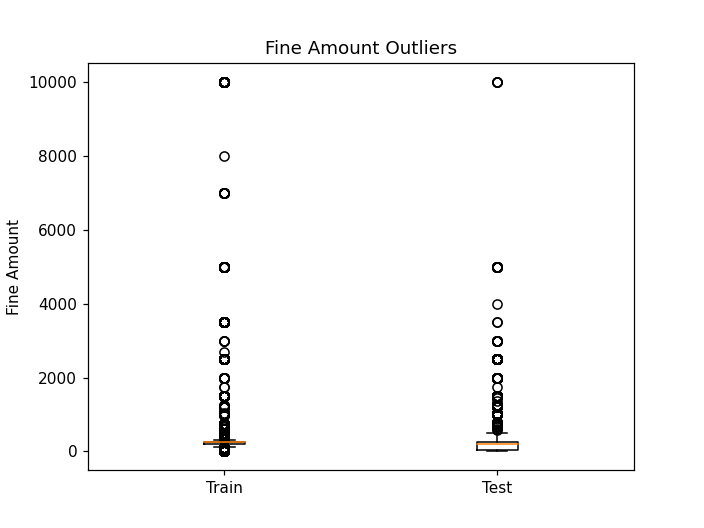

Text(0.5, 1.0, 'Fine Amount Outliers')

In [4]:
# Looking at outliers
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot((train['fine_amount'], test['fine_amount']), labels = ['Train', 'Test'])
ax.set_ylabel('Fine Amount')
ax.set_title('Fine Amount Outliers')

# As we can see, there are some extreme outliers, but since they're present in both sets 
# and we can't drop them from the test set, we should keep them.

In [5]:
# look for missing values
def Get_NA_Percentage(data):
    na_sum = data.isna().sum()
    return na_sum/(na_sum + data.count())

pd.DataFrame([Get_NA_Percentage(train), Get_NA_Percentage(test)], index=['train', 'test']).T\
                                                        .sort_values('test', ascending=False)

,train,test
non_us_str_code,0.999981,1.000000
grafitti_status,1.000000,0.963591
violation_zip_code,1.000000,0.606170
hearing_date,0.001420,0.036016
mailing_address_str_number,0.015999,0.016623
state,0.000525,0.005426
violator_name,0.000163,0.000459
zip_code,0.000006,0.000049
mailing_address_str_name,0.000019,0.000049
city,0.000000,0.000016


In [6]:
# merge data so that all changes apply to both datasets
train['train'] = 1
test['train'] = 0

df = pd.concat([train, test])

In [7]:
# There are only a few entries outside of US and none in the test set, so we'll just drop them along with the feature
df.drop(df[df['country'] != 'USA'].index, inplace=True)

# we can see that the top 3 features are basically useless since almost all of the data for them is missing
# so we'll get rid of them (and the country)
bad_features = ['non_us_str_code', 'grafitti_status', 'violation_zip_code', 'country']
df.drop(bad_features, axis=1, inplace=True)

In [8]:
# change date features to datetime
df.loc[:, 'ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'], format='%Y-%m-%d')
df.loc[:, 'hearing_date'] = pd.to_datetime(df['hearing_date'], format='%Y-%m-%d')

### Filling missing data
___

In [9]:
# fill missing data for hearing_date
df.loc[:, 'hearing_date'].fillna(method='ffill', inplace=True)
df.loc[:,'zip_code'].fillna(method='ffill', inplace=True)

# formatting badly formatted features
for feature in ['violation_street_name', 'mailing_address_str_name', 'state', 'city']:
    df.loc[:, feature] = df[feature].str.lower().str.replace('.','').str.replace(' ', '')
    df.loc[df[feature].astype(str).str.isdigit(), feature] = pd.NA


df.loc[df['mailing_address_str_number'].astype(str).str.contains('P.O|bo', regex=True), 'mailing_address_str_number'] = 0
df.loc[:, 'mailing_address_str_number'].fillna(0, inplace=True)

# filling mailing_address_str_name with 'p.o.box'
df.loc[df['mailing_address_str_name'].isna(), 'mailing_address_str_name'] = 'p.o.box' 

# reforming cities and states by each other
# starting with cities since there's less missing data
state_city = df[~df['city'].isna()].groupby('state').agg({'city' : lambda x: x.mode()[0]})
df.loc[df['city'].isna(), 'city'] = pd.merge(df[df['city'].isna()], state_city, 
                                             how='left', left_on='state', right_index=True)['city_y']
#df.fillna({'city': df['city'].mode()[0]}, inplace=True) # filling when both states and cities were missing
# now states
city_state = df[~df['state'].isna()].groupby('city').agg({'state' : lambda x: x.mode()[0]})
df.loc[df['state'].isna(), 'state'] = pd.merge(df[df['state'].isna()], city_state,
                                             how='left', left_on='city', right_index=True)['state_y']  
# filling when both states and cities were missing
df.fillna({'city': df['city'].mode()[0], 'state': df['state'].mode()[0]}, inplace=True)  

df.loc[df['violation_street_name'].str.contains('pobo|box', regex=True), 'violation_street_name'] = 'p.o.box'
df.loc[df['mailing_address_str_name'].str.contains('pobo|box', regex=True), 'mailing_address_str_name'] = 'p.o.box'
df.loc[df['mailing_address_str_number'].astype(str).str.lower()\
       .str.contains('p|o|b|x', regex=True), 'mailing_address_str_number'] = 0

# by now, we only have violator_name (and compliance from test set) left, which we'll deal with later
df.columns[df.isna().sum() > 0]

Index(['violator_name', 'compliance'], dtype='object')

## Feature Engenireeng
___

In [10]:
# adding coordinates
coordinates = pd.merge(latlons, addresses, how='inner', on='address')
df = pd.merge(df, coordinates, how='left', on='ticket_id').drop('address', axis=1)
df.loc[:,'lat'].fillna(method='ffill', inplace=True)
df.loc[:,'lon'].fillna(method='ffill', inplace=True)

In [11]:
# we'll use labeling on all categorical data

# we'll keep our missing violators to label them later
missing_names_indeces = df[df['violator_name'].isna()].index

for feature in df.select_dtypes(['object']).columns:
    df.loc[:, feature] = LabelEncoder().fit_transform(df[feature].astype(str))

df = df.apply(pd.to_numeric)
df.loc[missing_names_indeces, 'violator_name'] = -1

In [12]:
# inspector_exp - how experienced inspector is
inspector_exps = df.groupby('inspector_name').agg({'compliance' : 'count'}).rename(columns={'compliance' : 'inspector_exp'})
df = pd.merge(df, inspector_exps, how='left', left_on='inspector_name', right_index=True)

In [13]:
# previous_violations - number of violation a person has commited before
# compliance_rate - rate at which they complied during previous violations (not counting the current one)

repeated_violators = df.groupby('violator_name').agg({'ticket_id' : 'count'})
repeated_violators.columns = ['violations_num']
repeated_violators.drop(-1, inplace=True) # dropping unknown violators, assuming they're all different people
repeated_violators = repeated_violators.drop(repeated_violators[repeated_violators['violations_num'] <= 1].index)

only_repeated = df[df['violator_name'].isin(repeated_violators.index)]\
                .groupby(['violator_name', 'ticket_issued_date']).agg({'compliance' : 'mean', 'train' : 'max'})

prev_violation_info = only_repeated.groupby(level=0).agg({'compliance' : ['cumcount', 'cumsum'], 'train' : 'cummax'})
prev_violation_info.columns = ['previous_violations', 'compliance_rate', 'was_in_train']
# adjusting compliance_rate to not know about the current complience state and to be between 0 and 1
prev_violation_info['compliance_rate'] -= only_repeated['compliance']
prev_violation_info.loc[prev_violation_info['previous_violations'] > 0, 'compliance_rate']\
                                            /= prev_violation_info['previous_violations']

# fixing the problem where offenders that were in both train and test sets get NA on their test entries
prev_violation_info.fillna(method='ffill', inplace=True)
prev_violation_info['compliance_rate'] *= prev_violation_info['was_in_train']
prev_violation_info.drop('was_in_train', axis=1, inplace=True)

df = pd.merge(df, prev_violation_info.reset_index(), how='left', on=['violator_name', 'ticket_issued_date'])

# filling the data for the first time offenders
df.loc[:, 'previous_violations'].fillna(0, inplace=True)
df.loc[:, 'compliance_rate'].fillna(0, inplace=True)

In [14]:
# total_cost - total cost of the fine with all the additions
df['total_cost'] = df[['fine_amount', 'admin_fee', 'state_fee', 
                       'late_fee', 'clean_up_cost']].sum(axis=1) - df['discount_amount']

# state_median_cost - median total_cost by states
state_cost = df.groupby('state').agg({'total_cost' : 'median'})
state_cost.columns = ['state_median_cost']
df = pd.merge(df, state_cost, how='left', left_on='state', right_index=True)

# agency_median_cost - median total_cost by agencies
agency_cost = df.groupby('agency_name').agg({'total_cost' : 'median'})
agency_cost.columns = ['agency_median_cost']
df = pd.merge(df, agency_cost, how='left', left_on='agency_name', right_index=True)

## Training Model
___

In [15]:
train = df[df['train'] == 1]
test = df[df['train'] == 0].drop('compliance', axis=1)

train.drop('train', axis=1, inplace=True)
test.drop('train', axis=1, inplace=True)

# we'll set some validation set from the train set
# we're not using train_test_split function because getting random split would cause data leakage
# we need the all of the test data to be from later dates than the train data

threshold = train['ticket_issued_date'].quantile(0.75, interpolation='nearest')
X_train = train[train['ticket_issued_date'] < threshold].drop('compliance', axis=1)
y_train = train[train['ticket_issued_date'] < threshold]['compliance']
X_test = train[train['ticket_issued_date'] >= threshold].drop('compliance', axis=1)
y_test = train[train['ticket_issued_date'] >= threshold]['compliance']

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Using Random Forest

In [16]:
forest_clf = RandomForestClassifier(random_state=0)
params = {'criterion' : ['gini', 'entropy'], 'max_depth' : [15, 30, 50, 100], 'max_features' : ['auto', 'sqrt', 'log2']}

# using code below we found the optimal (suboptimal) parameters: criterion='entropy', max_depth=15, max_features='log2'

#ran_search = RandomizedSearchCV(forest_clf, params, verbose=100, random_state=0, cv=3, scoring='roc_auc')
#ran_search.fit(X_train, y_train)

In [17]:
forest_clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', random_state=0)
forest_clf.fit(X_train, y_train)

probs = list(map(lambda x: x[1], forest_clf.predict_proba(X_test)))
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
metrics.auc(fpr, tpr)

0.799498521002682

<IPython.core.display.Javascript object>


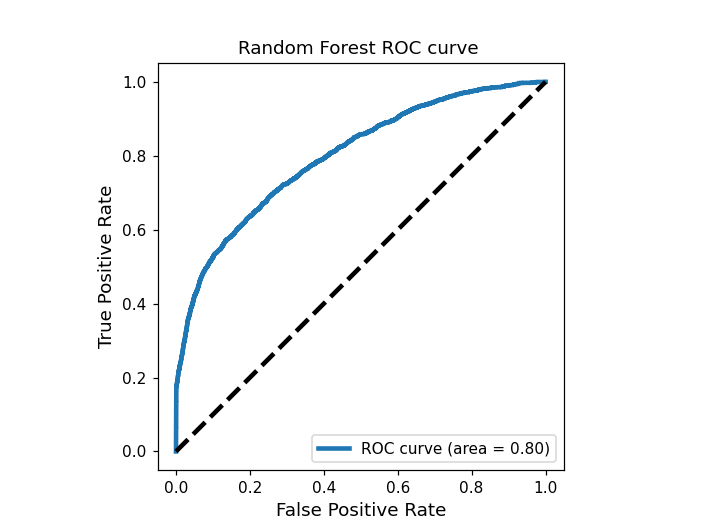

<ipython-input-18-931c7bf3575d>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


In [18]:
# plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(metrics.auc(fpr, tpr)))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest ROC curve ')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')
plt.axes().set_aspect('equal')

<IPython.core.display.Javascript object>


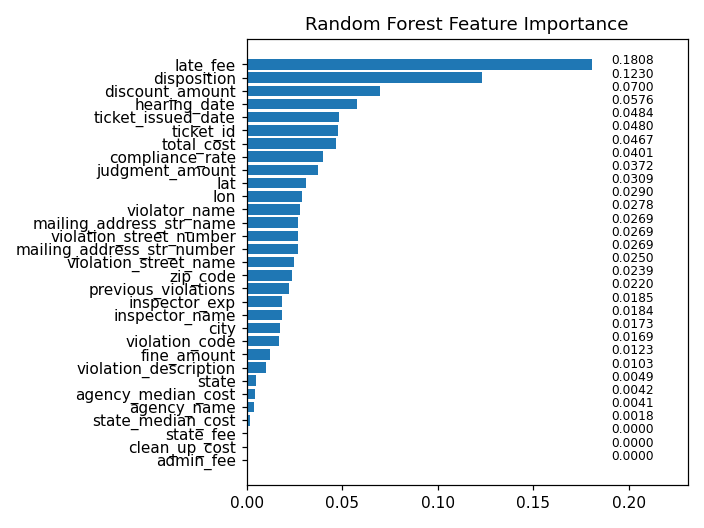

In [19]:
# plotting feature importance
feat_imp = pd.Series(forest_clf.feature_importances_, index=X_train.columns).sort_values()

plt.figure()
plt.barh(feat_imp.index, feat_imp.values)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.xlim(0, feat_imp.max()+0.05)

x_txt = feat_imp.max() + 0.01
for feat, imp in zip(feat_imp.index, feat_imp.values):
    plt.text(x_txt, feat, '{:0.4f}'.format(imp), color='black', fontsize=8)

### Trying Gradient Boosting 

In [20]:
# I tried different options, these parameters seem to be optimal

grdboost_clf = GradientBoostingClassifier(loss='exponential' ,learning_rate=0.01, n_estimators=2000)
grdboost_clf.fit(X_train, y_train)

probs = list(map(lambda x: x[1], grdboost_clf.predict_proba(X_test)))
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
metrics.auc(fpr, tpr)

0.8138706486886838

<IPython.core.display.Javascript object>


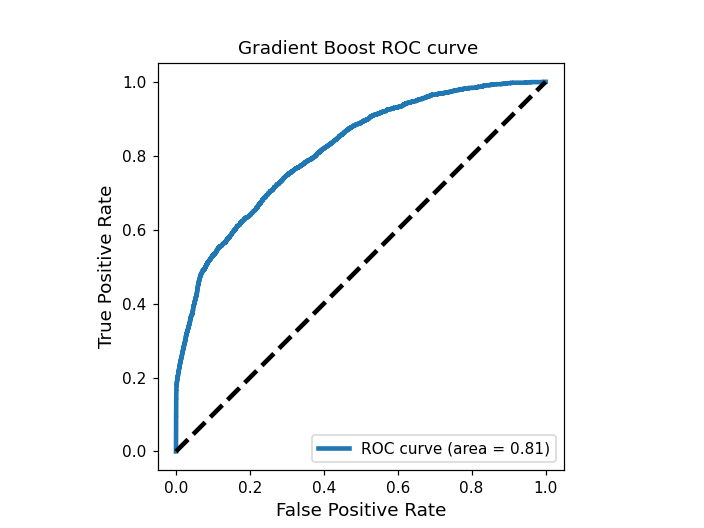

<ipython-input-21-ba8e1bcf9efe>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


In [21]:
# plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(metrics.auc(fpr, tpr)))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Gradient Boost ROC curve ')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')
plt.axes().set_aspect('equal')

<IPython.core.display.Javascript object>


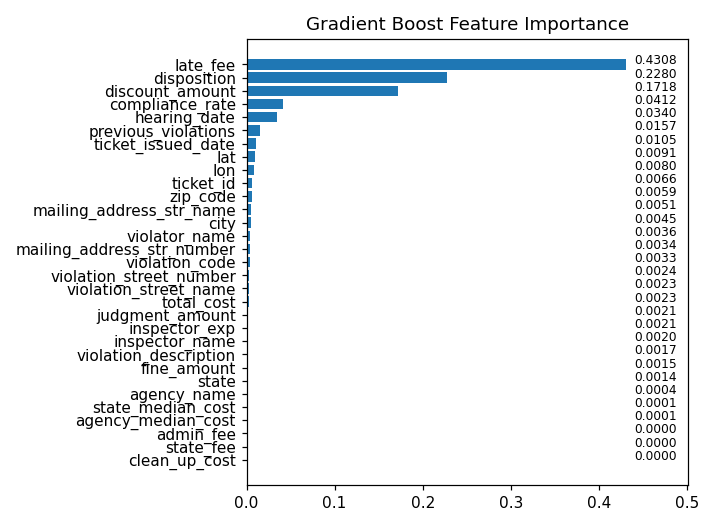

In [23]:
# plotting feature importance
feat_imp = pd.Series(grdboost_clf.feature_importances_, index=X_train.columns).sort_values()

plt.figure()
plt.barh(feat_imp.index, feat_imp.values)
plt.title('Gradient Boost Feature Importance')
plt.tight_layout()
plt.xlim(0, feat_imp.max()+0.07)

x_txt = feat_imp.max() + 0.01
for feat, imp in zip(feat_imp.index, feat_imp.values):
    plt.text(x_txt, feat, '{:0.4f}'.format(imp), color='black', fontsize=8)

In conclusion, we got ROC AUC of around 0.81 using gradient boosting classifier, although random forest isn't far behind and is much faster to train.